In [2]:
#@title ## Imports
import os
import numpy as np
import math
import sys
import time
import matplotlib.pyplot as plt
import torch.autograd.forward_ad as fwAD
import torch
import seaborn as sns
from helpers import optimize, plot_loss

First, I try using normal backprop to optimize the basic square function

Initial_loss: 16.00


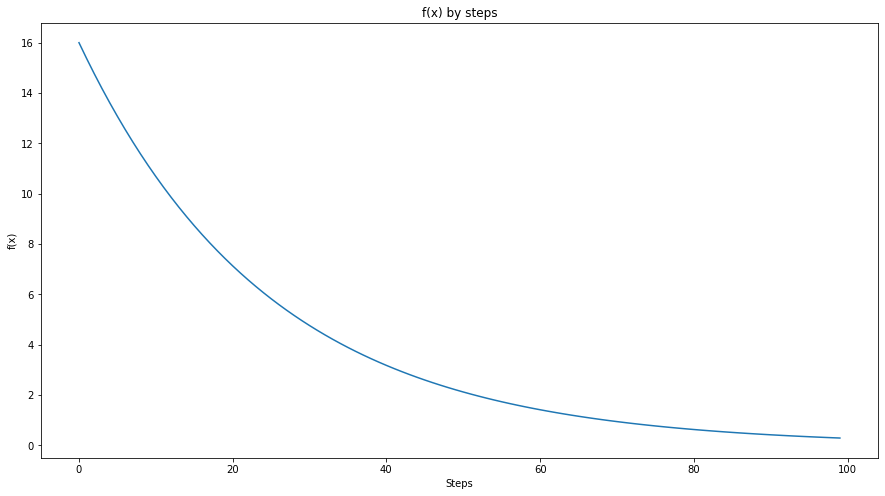

In [5]:
def square(x):
    return x**2

params = torch.tensor([4.], requires_grad = True)
optimizer = torch.optim.SGD([params], 1e-2)

losses, grads =  optimize(optimizer, square, params, 100)


Then, we proceed to the Beale function from the original paper.

Initial_loss: 7.57


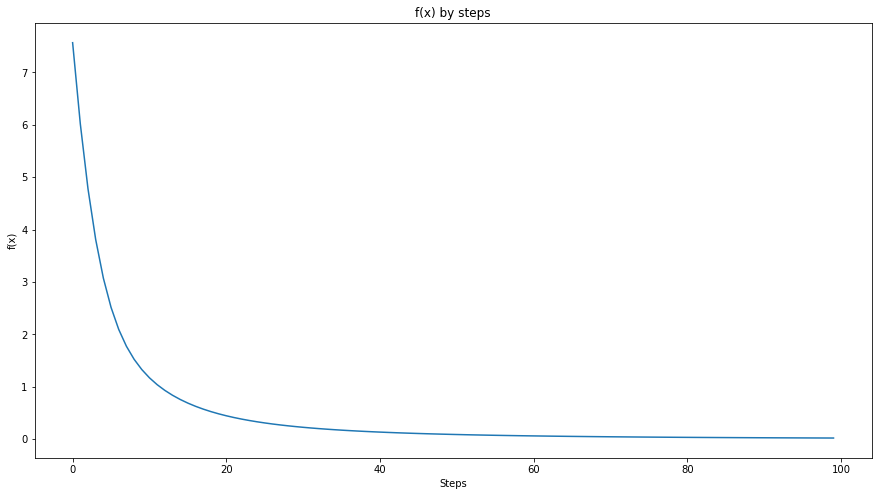

In [4]:
# defining the Beale function
def beale(params):
    x = params[0]
    y = params[1]
    return (1.5-x+x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

x = torch.tensor([np.random.rand()], requires_grad = True)
y = torch.tensor([np.random.rand()], requires_grad = True)
params = [x, y]
#params = torch.tensor([x, y], requires_grad=True)
optimizer = torch.optim.SGD(params, 0.02)

losses, grads =  optimize(optimizer, beale, params, 100)




Finally, we implement the Rosenbrock function.

Initial_loss: 12.59


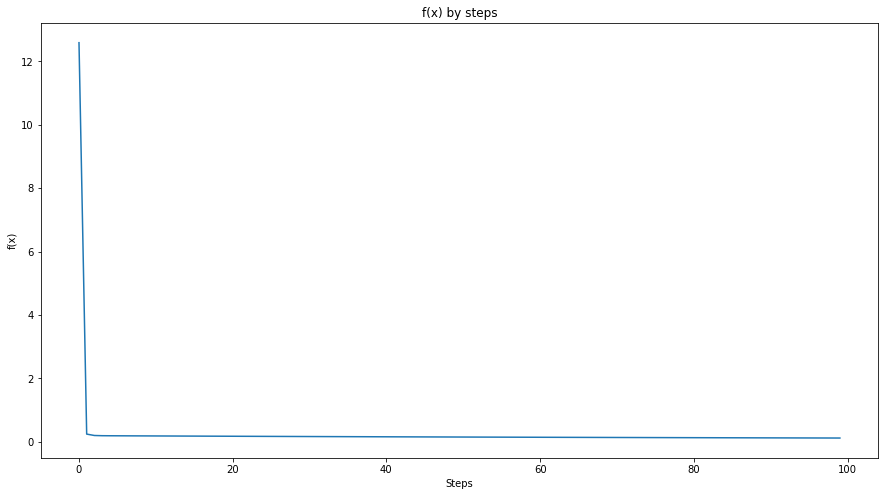

In [11]:
def rosenbrock(params, a=1, b=100):
    x = params[0]
    y = params[1]
    return (a-x)**2 + b*(y-x**2)**2

x = torch.tensor([np.random.rand()], requires_grad = True)
y = torch.tensor([np.random.rand()], requires_grad = True)
params = [x, y]
#params = torch.tensor([x, y], requires_grad=True)
optimizer = torch.optim.SGD(params, 0.003)

losses, grads =  optimize(optimizer, rosenbrock, params, 100)